In [ ]:
# Google Colab specific code for mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# # Define the directory path on your Google Drive
# # Replace 'Your_directory' with the actual directory
# directory = '/content/drive/My Drive/Colab Notebooks/ML4GST/'

# # Now use this directory for reading and writing data
# data_template_filename = directory + "dataset.txt"
# gst_dir = directory + "test_gst_dir"

Mounted at /content/drive


In [1]:
import os

In [2]:
# Change the working directory to the desired path
os.chdir(r"C:\Users\ULTIMATEWOWEE\Documents\ML4GST")

# Verify that the working directory has been changed
print("Current working directory:", os.getcwd())


Current working directory: C:\Users\ULTIMATEWOWEE\Documents\ML4GST


In [ ]:
pip install pygsti

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 37.0 MB/s eta 0:00:00


In [ ]:
import pygsti
import pygsti.algorithms.fiducialselection as fidsel
import pygsti.algorithms.germselection as germsel
import numpy as np
import pandas as pd

# Define the Pauli Transfer Matrices for the gates
# I = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
# X_pi_4 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, np.cos(np.pi/4), -np.sin(np.pi/4)], [0, 0, np.sin(np.pi/4), np.cos(np.pi/4)]])
# Y_pi_2 = np.array([[1, 0, 0, 0], [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)], [0, 0, 1, 0], [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]])

# Create the explicit model
ideal_target_model = pygsti.models.create_explicit_model_from_expressions(
    [('Q0',)], ['Gi', 'Gx', 'Gy'],
    ["I(Q0)", "X(pi/4,Q0)", "Y(pi/2,Q0)"])

class MyXPi2Operator(pygsti.modelmembers.operations.DenseOperator):
    def __init__(self):
        #initialize with no noise
        super(MyXPi2Operator,self).__init__(np.identity(4,'d'), 'pp', "densitymx") # this is *super*-operator, so "densitymx"
        self.from_vector([0.0, 0.1])

    @property
    def num_params(self):
        return 2 # we have two parameters

    def to_vector(self):
        return np.array([self.depol_amt, self.over_rotation],'d') #our parameter vector

    def from_vector(self, v, close=False, dirty_value=True):
        #initialize from parameter vector v
        self.depol_amt = v[0]
        self.over_rotation = v[1]

        # print(f'depol_amt: {self.depol_amt}, over_rotation: {self.over_rotation}')

        theta = (np.pi/4 + self.over_rotation)/2
        a = 1.0-self.depol_amt
        b = a*2*np.cos(theta)*np.sin(theta)
        c = a*(np.sin(theta)**2 - np.cos(theta)**2)

        # print(f'a: {a}, b: {b}, c: {c}')

        # ._ptr is a member of DenseOperator and is a numpy array that is
        # the dense Pauli transfer matrix of this operator
        # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
        self._ptr[:,:] = np.array([[1,   0,   0,   0],
                                  [0,   a,   0,   0],
                                  [0,   0,   c,  -b],
                                  [0,   0,   b,   c]],'d')
        self.dirty = dirty_value  # mark that parameter vector may have changed

    def transform(self, S):
        # Update self with inverse(S) * self * S (used in gauge optimization)
        raise NotImplementedError("MyXPi2Operator cannot be transformed!")

import copy
target_model = copy.deepcopy(ideal_target_model)
target_model.operations[('Gx')] = MyXPi2Operator()
print('target_model: \n', target_model)
print('ideal_target_model: \n', ideal_target_model)



target_model: 
 rho0 = FullState with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: FullPOVMEffect with dimension 4
 0.71   0   0-0.71



Gi = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gx = 
MyXPi2Operator with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0-0.63-0.77
   0   0 0.77-0.63


Gy = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0   0   0 1.00
   0   0 1.00   0
   0-1.00   0   0




ideal_target_model: 
 rho0 = FullState with dimension 4
 0.71   0   0 0.71


Mdefault = UnconstrainedPOVM with effect vectors:
0: FullPOVMEffect with dimension 4
 0.71   0   0 0.71

1: FullPOVMEffect with dimension 4
 0.71   0   0-0.71



Gi = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00   0   0
   0   0 1.00   0
   0   0   0 1.00


Gx = 
FullArbitraryOp with shape (4, 4)
 1.00   0   0   0
   0 1.00  

In [ ]:
# Automatic selection of fiducials and germs using "laissez-faire" method
prepFiducials, measFiducials = fidsel.find_fiducials(ideal_target_model)
germs = germsel.find_germs(ideal_target_model, seed = 1234)

Initial Length Available Fiducial List: 7
Length Available Fiducial List Dropped Identities and Duplicates: 7
Using GRASP algorithm.
Preparation fiducials:
['{}', 'Gy', 'GxGx', 'GyGy']
Score: 32.0
Measurement fiducials:
['{}', 'Gy', 'GxGx']
Score: 9.999999999999996
Initial Length Available Germ List: 196
Length Available Germ List After Deduping: 59
Length Available Germ List After Dropping Random Fraction: 59
Length Available Germ List After Adding Back In Forced Germs: 59
Memory estimate of 0.0 GB for all-Jac mode.
Memory estimate of 0.0 GB for single-Jac mode.
Using greedy algorithm.
Constructed germ set:
['Gi', 'Gx', 'Gy', 'GxGxGy', 'GiGxGx', 'GiGyGx', 'GiGyGxGxGyGy', 'GiGyGyGyGxGx', 'GxGxGyGxGyGy', 'GiGxGyGyGyGx']
Score: major=-34.0 minor=711.6500383006758, N: 34


In [ ]:
print(f'prepFiducials: {prepFiducials} \n measFiducials: {measFiducials} \n germs: {germs}')

prepFiducials: [Circuit({}), Circuit(Gy), Circuit(GxGx), Circuit(GyGy)] 
 measFiducials: [Circuit({}), Circuit(Gy), Circuit(GxGx)] 
 germs: [Circuit(Gi), Circuit(Gx), Circuit(Gy), Circuit(GxGxGy), Circuit(GiGxGx), Circuit(GiGyGx), Circuit(GiGyGxGxGyGy), Circuit(GiGyGyGyGxGx), Circuit(GxGxGyGxGyGy), Circuit(GiGxGyGyGyGx)]


In [ ]:
# Generate a list of circuits using the long-sequence gate set tomography (LSGST) method
maxLengths = [2**n for n in range(5)]

listOfExperiments = pygsti.circuits.create_lsgst_circuits(
    target_model, prepFiducials, measFiducials, germs, maxLengths)

# Simulate the probability outcomes of these circuits
ds = pygsti.data.simulate_data(target_model, listOfExperiments, num_samples=1000,
                                            sample_error="binomial", seed=1234)
# print(ds)

pygsti.io.write_dataset("Custom_1Q_XYI_dataset_abc.txt", ds, outcome_label_order=['0','1'])

# Convert the probabilities to a DataFrame and save to a CSV file

In [3]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam

# Load the sorted data directly from the modified CSV
df_sorted = pd.read_csv('Sorted_Encoded_Padded_Probabilities.csv')

def prepare_data(df_part):
    # Extracting features and labels
    X = df_part['Padded'].apply(lambda x: [int(xi) for xi in x.strip('[]').split()]).to_list()
    y = df_part[['Prob1', 'Prob2']].values

    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    return X, y

X, y = prepare_data(df_sorted)

# Create new input data
X_new = [X, y]

# Split the original input (X[0]) and target labels (y) into training and test sets
X_train_0, X_test_0, y_train, y_test = train_test_split(X_new[0], y, test_size=0.2, random_state=42)

# Manually combine the split y labels into the X data
X_train = [np.array(X_train_0), np.array(y_train)]
X_test = [np.array(X_test_0), np.array(y_test)]

# Convert y data to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)



In [ ]:
X_train[0]

array([[2, 2, 2, ..., 0, 0, 0],
       [2, 1, 0, ..., 0, 0, 0],
       [3, 2, 2, ..., 0, 0, 0],
       ...,
       [2, 3, 2, ..., 0, 0, 0],
       [2, 2, 3, ..., 0, 0, 0],
       [2, 1, 1, ..., 0, 0, 0]])

In [ ]:
X_train[0][0]

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
X_train[1]

array([[0.49 , 0.51 ],
       [0.492, 0.508],
       [0.526, 0.474],
       [0.227, 0.773],
       [0.   , 1.   ],
       [0.922, 0.078],
       [0.513, 0.487],
       [0.519, 0.481],
       [0.501, 0.499],
       [0.715, 0.285],
       [0.474, 0.526],
       [0.969, 0.031],
       [0.41 , 0.59 ],
       [0.508, 0.492],
       [0.519, 0.481],
       [0.586, 0.414],
       [0.95 , 0.05 ],
       [0.498, 0.502],
       [0.491, 0.509],
       [0.644, 0.356],
       [0.475, 0.525],
       [0.491, 0.509],
       [0.594, 0.406],
       [0.294, 0.706],
       [0.668, 0.332],
       [1.   , 0.   ],
       [0.525, 0.475],
       [0.5  , 0.5  ],
       [0.403, 0.597],
       [0.   , 1.   ],
       [0.501, 0.499],
       [0.418, 0.582],
       [0.511, 0.489],
       [0.323, 0.677],
       [0.   , 1.   ],
       [0.383, 0.617],
       [0.037, 0.963],
       [0.983, 0.017],
       [0.821, 0.179],
       [0.036, 0.964],
       [1.   , 0.   ],
       [0.052, 0.948],
       [0.486, 0.514],
       [0.1

In [ ]:
X_train[1][0]

array([0.49, 0.51])

In [4]:
class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, decay_steps, decay_rate):
        super().__init__()
        self.initial_learning_rate = initial_learning_rate
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        return self.initial_learning_rate / (1 + self.decay_rate * step / self.decay_steps)

    def get_config(self):
        return {
            "initial_learning_rate": self.initial_learning_rate,
            "decay_steps": self.decay_steps,
            "decay_rate": self.decay_rate
        }


# class CustomLearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):

#   def __init__(self, initial_learning_rate):
#     self.initial_learning_rate = initial_learning_rate

#   def __call__(self, step):
#      return self.initial_learning_rate / (step + 1)

# Define model
# model = Sequential([
#     Dense(20, activation='relu', input_shape=(len(X_train[0]),)),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(2, activation='sigmoid'),  # Sigmoid function outputs in the range [0, 1]
# ])
# model = Sequential([
#     Dense(20, activation='relu', input_shape=(len(X_train[0]),)),
#     Dense(128, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(2, activation='relu'),
# ])

# # Scale model output to range [0, 2pi]
# scaling_layer = Lambda(lambda x: x * 2 * math.pi)
# model.add(scaling_layer)

# Define model architecture
input_X = Input(shape=(len(X_train[0][0]),), name='input_X')
input_y = Input(shape=(len(X_train[1][0]),), name='input_y')

# Original branch
x1 = Dense(20, activation='relu')(input_X)
x1 = Dense(128, activation='relu')(x1)

# New branch
x2 = Dense(2, activation='relu')(input_y)
x2 = Dense(64, activation='relu')(x2)

# Concatenate branches
merged = Concatenate()([x1, x2])
merged = Dense(64, activation='relu')(merged)
merged = Dense(2, activation='relu')(merged)

# Create and compile model
model = Model(inputs=[input_X, input_y], outputs=merged)

# Compile model

initial_learning_rate = 1e-5
decay_steps = 1000
decay_rate = 0.01
lr_schedule = CustomLearningRateScheduler(initial_learning_rate, decay_steps, decay_rate)
# lr_schedule = CustomLearningRateScheduler(initial_learning_rate)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mean_squared_error')

# Custom X gate
def custom_X(depol_amt, over_rotation):

  # print(f'depol_amt: {self.depol_amt}, over_rotation: {self.over_rotation}')

  theta = (math.pi/4 + over_rotation)/2
  a = 1.0-depol_amt
  b = a*2*tf.math.cos(theta)*tf.math.sin(theta)
  c = a*(tf.math.sin(theta)**2 - tf.math.cos(theta)**2)

  # print(f'a: {a}, b: {b}, c: {c}')

  # ._ptr is a member of DenseOperator and is a numpy array that is
  # the dense Pauli transfer matrix of this operator
  # Technical note: use [:,:] instead of direct assignment so id of self._ptr doesn't change
  custom_X_arr = tf.convert_to_tensor([[1,   0,   0,   0],
                            [0,   a,   0,   0],
                            [0,   0,   c,  -b],
                            [0,   0,   b,   c]], dtype=tf.float32)

  return custom_X_arr


# Define gate application function
def apply_gate(state, depol_amt, over_rotation, label):
    # Construct arrays using NumPy
    # Define gates in PTM form
    I_np = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]], dtype=np.float32)  #Gi

    Y_pi_2_np = np.array([[1, 0, 0, 0],
                          [0, np.cos(np.pi/2), 0, np.sin(np.pi/2)],
                          [0, 0, 1, 0],
                          [0, -np.sin(np.pi/2), 0, np.cos(np.pi/2)]], dtype=np.float32) #Gy

    # Normalized State corresponding to |0⟩ in Pauli basis
    # state_np = np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32)

    # Convert NumPy arrays to TensorFlow tensors
    I = tf.convert_to_tensor(I_np)
    Y_pi_2 = tf.convert_to_tensor(Y_pi_2_np)
    # state = tf.convert_to_tensor(state_np)

    # X_theta = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(theta_value), 0, tf.math.sin(theta_value)],
    #                        [0, 0, 1, 0], [0, -tf.math.sin(theta_value), 0, tf.math.cos(theta_value)]], dtype=tf.float32)  # Gx

    X_theta = custom_X(depol_amt, over_rotation)
    # print('current label: ', label)

    if label == 1:
        return tf.linalg.matmul(X_theta, tf.reshape(state, [-1, 1]))
    elif label == 2:
        return tf.linalg.matmul(Y_pi_2, tf.reshape(state, [-1, 1]))
    elif label == 3:
        return tf.linalg.matmul(I, tf.reshape(state, [-1, 1]))
    else:
        return state  # If label is 0, don't apply any gate


# def apply_gate_sequence(single_gate_sequence):
#     # Initialize state in Pauli basis
#     state = tf.convert_to_tensor([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=tf.float32)

#   # Apply each gate in the sequence
#     # print('model(single_gate_sequence[tf.newaxis, :]) ->', model(single_gate_sequence[tf.newaxis, :]))
#     depol_amt, over_rotation = tf.squeeze(model(single_gate_sequence[tf.newaxis, :])) # Predict depolar_error, over_rotation for the current gate sequence
#     # print('theta_value: ', theta_value)
#     # depol_amt = tf.clip_by_value(tf.squeeze(depol_amt), 0, 0.1)
#     # over_rotation = tf.clip_by_value(tf.squeeze(over_rotation), 0, 0.1)
#     # print(f"depol_amt: {depol_amt}, over_rotation: {over_rotation}")
#     # print('squeezed theta_value: ', theta_value)
#     for i in range(tf.shape(single_gate_sequence)[0]):
#       if single_gate_sequence[i] == 0:
#         break
#       # print('tf.shape(single_gate_sequence): ', tf.shape(single_gate_sequence))
#       # print('tf.shape(single_gate_sequence[0]): ', tf.shape(single_gate_sequence)[0])
#       # print('single_gate_sequence[i]: ', single_gate_sequence[i])
#       state = apply_gate(state, depol_amt, over_rotation, single_gate_sequence[i])
#       # print('current state: ', state)

#     return state

def apply_gate_sequence(single_gate_sequence, single_y_label):
    # Initialize state in Pauli basis
    state = tf.convert_to_tensor([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=tf.float32)

    # print("Shape of single_gate_sequence:", tf.shape(single_gate_sequence))
    # print("Shape of single_y_label:", tf.shape(single_y_label))
    # print("Shape of model input single_gate_sequence:", tf.shape(single_gate_sequence[tf.newaxis, :]))
    # print("Shape of model input single_gate_sequence:", tf.shape(single_y_label[tf.newaxis, :]))


    # Apply each gate in the sequence
    depol_amt, over_rotation = tf.squeeze(model([single_gate_sequence[tf.newaxis, :], single_y_label[tf.newaxis, :]])) # Predict depolar_error, over_rotation for the current gate sequence

    for i in range(tf.shape(single_gate_sequence)[0]):
        if single_gate_sequence[i] == 0:
            break
        state = apply_gate(state, depol_amt, over_rotation, single_gate_sequence[i])

    return state



def compute_probabilities(ptm_vector):
    # PTM representations for |0> and |1> states
    ptm_0 = tf.constant([1, 0, 0, 1], dtype=tf.float32)
    ptm_1 = tf.constant([1, 0, 0, -1], dtype=tf.float32)
    # ptm_0 = tf.convert_to_tensor([1, 0, 0, 1], dtype=tf.float32)
    # ptm_1 = tf.convert_to_tensor([1, 0, 0, -1], dtype=tf.float32)

    # Normalize the vectors
    ptm_vector = tf.squeeze(tf.linalg.l2_normalize(ptm_vector))
    ptm_0 = tf.linalg.l2_normalize(ptm_0)
    ptm_1 = tf.linalg.l2_normalize(ptm_1)

    # Compute dot products
    prob_0 = tf.tensordot(ptm_vector, ptm_0, axes=1)
    prob_1 = tf.tensordot(ptm_vector, ptm_1, axes=1)

    return tf.stack([prob_0, prob_1])


# Define loss function
loss_fn = MeanSquaredError()

# Define training loop
# def train_step(X, y):
#     with tf.GradientTape() as tape:
#       batched_final_states = []
#       batched_probabilities = []

#       # Process each sequence in the batch individually
#       for i in range(tf.shape(X)[0]):
#           single_sequence = tf.gather(X, i, axis=0)
#           final_state = apply_gate_sequence(single_sequence)
#           probabilities = compute_probabilities(final_state)
#           batched_final_states.append(final_state)
#           # print('batched_final_states: ', batched_final_states)
#           batched_probabilities.append(probabilities)
#           # print('batched_probabilities: ', batched_probabilities)

#       batched_final_states = tf.stack(batched_final_states)
#       # print('batched_final_states: ', batched_final_states)
#       # print('batched_final_states.shape: ', batched_final_states.shape)
#       batched_probabilities = tf.stack(batched_probabilities)
#       # print('batched_probabilities: ', batched_probabilities)
#       # print('batched_probabilities.shape: ', batched_probabilities.shape)


#       loss = loss_fn(y, batched_probabilities)
#       # print('loss: ', loss)

#     grads = tape.gradient(loss, model.trainable_weights)
#     optimizer.apply_gradients(zip(grads, model.trainable_weights))
#     return loss

def train_step(X, y):
    with tf.GradientTape() as tape:
        batched_final_states = []
        batched_probabilities = []

        # print("Shape of X[0]:", tf.shape(X[0]))
        # print("Shape of X[1]:", tf.shape(X[1]))
        # print("Shape of y:", tf.shape(y))

        # Process each sequence in the batch individually
        # print('tf.shape(X[0])[0]:', tf.shape(X[0])[0])
        for i in range(tf.shape(X[0])[0]):
            single_sequence = tf.gather(X[0], i, axis=0)
            single_y_label = tf.gather(X[1], i, axis=0)
            final_state = apply_gate_sequence(single_sequence, single_y_label)
            probabilities = compute_probabilities(final_state)
            batched_final_states.append(final_state)
            batched_probabilities.append(probabilities)

        batched_final_states = tf.stack(batched_final_states)
        batched_probabilities = tf.stack(batched_probabilities)

        loss = loss_fn(y, batched_probabilities)

    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss


# Define validation loop (similar to training loop but without gradients)
# def validate_step(X, y, print_results = False):
#     batched_final_states = []
#     batched_probabilities = []
#     # batched_thetas = []
#     batched_errors = []

#     for i in range(tf.shape(X)[0]):
#         single_sequence = tf.gather(X, i, axis=0)
#         final_state = apply_gate_sequence(single_sequence)
#         probabilities = compute_probabilities(final_state)
#         batched_final_states.append(final_state)
#         batched_probabilities.append(probabilities)
#         if print_results == True:
#             theta_value = tf.squeeze(model(single_sequence[tf.newaxis, :])) # Predict theta for the current gate
#             depol_amt, over_rotation = tf.squeeze(model(single_sequence[tf.newaxis, :])) # Predict depolar_error, over_rotation for the current gate sequence
#             # batched_thetas.append(theta_value)
#             batched_errors.append(tf.stack([depol_amt, over_rotation]))


#     batched_final_states = tf.stack(batched_final_states)
#     batched_probabilities = tf.stack(batched_probabilities)
#     loss = loss_fn(y, batched_probabilities)
#     if print_results == True:
#       # print('batched_thetas: ', batched_thetas)
#       print('batched_errors: ', batched_errors)
#     return loss

def validate_step(X, y, print_results = False):
    batched_final_states = []
    batched_probabilities = []
    batched_errors = []

    for i in range(tf.shape(X[0])[0]):
        single_sequence = tf.gather(X[0], i, axis=0)
        single_y_label = tf.gather(X[1], i, axis=0)
        final_state = apply_gate_sequence(single_sequence, single_y_label)
        probabilities = compute_probabilities(final_state)
        batched_final_states.append(final_state)
        batched_probabilities.append(probabilities)
        if print_results == True:
            depol_amt, over_rotation = tf.squeeze(model([single_sequence[tf.newaxis, :], single_y_label[tf.newaxis, :]])) # Predict depolar_error, over_rotation for the current gate sequence
            batched_errors.append(tf.stack([depol_amt, over_rotation]))

    batched_final_states = tf.stack(batched_final_states)
    batched_probabilities = tf.stack(batched_probabilities)
    loss = loss_fn(y, batched_probabilities)
    if print_results == True:
        print('batched_errors: ', batched_errors)
    return loss


In [5]:
# Directory to save the model and weights
model_save_dir = "saved_models"
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [6]:
# Training loop
EPOCHS = 100
BATCH_SIZE = 64
num_parts = 3
part_size = len(df_sorted) // num_parts

total_epochs_elapsed = 0  # Counter for total number of epochs elapsed

# Lists to store the mean train and validation losses for each epoch across all parts
all_train_losses = []
all_val_losses = []

for part in range(num_parts):
    # Determine the dataset subset for the current part
    end_idx = (part + 1) * part_size
    X_subset, y_subset = prepare_data(df_sorted.iloc[:end_idx])

    # Convert X_subset and y_subset to a single numpy array
    X_subset = np.array(X_subset)
    X_subset = [X_subset, y_subset]
    y_subset = np.array(y_subset)


    for epoch in range(EPOCHS):
        train_losses_per_epoch = []
        val_losses_per_epoch = []

        for i in range(0, len(X_subset[0]), BATCH_SIZE):
            # print('len of X_subset[0][i:i+BATCH_SIZE]: ', len(X_subset[0][i:i+BATCH_SIZE]))
            X_batch = [X_subset[0][i:i+BATCH_SIZE], X_subset[1][i:i+BATCH_SIZE]]
            y_batch = y_subset[i:i+BATCH_SIZE]

            # Training and validation steps remain unchanged
            train_loss = train_step(X_batch, y_batch)
            val_loss = validate_step(X_test, y_test)
            train_losses_per_epoch.append(train_loss)
            val_losses_per_epoch.append(val_loss)

        mean_train_loss = np.mean(train_losses_per_epoch)
        mean_val_loss = np.mean(val_losses_per_epoch)

        # Store the mean losses for this epoch
        all_train_losses.append(mean_train_loss)
        all_val_losses.append(mean_val_loss)

        total_epochs_elapsed += 1
        print(f"Part: {part+1}/{num_parts}, Epoch: {epoch+1}/{EPOCHS}, Total Epochs: {total_epochs_elapsed}, Train Loss: {mean_train_loss}, Validation Loss: {mean_val_loss}")

        if total_epochs_elapsed % 20 == 0:
          model_path = os.path.join(model_save_dir, f"model_epoch_{total_epochs_elapsed}")
          weights_path = os.path.join(model_save_dir, f"weights_epoch_{total_epochs_elapsed}")
          tf.saved_model.save(model, model_path)
          model.save_weights(weights_path)
          
          print(f"Model and weights saved at epoch {total_epochs_elapsed}")
            
          # Convert the recorded losses into a DataFrame
          loss_df = pd.DataFrame({
          'Epoch': list(range(1, len(all_train_losses) + 1)),
          'Training_Loss': all_train_losses,
          'Validation_Loss': all_val_losses
           })

          # Save the DataFrame to a CSV file
          loss_df.to_csv(f'losses_{total_epochs_elapsed}.csv', index=False)  
          
          print(f"Losses saved at epoch {total_epochs_elapsed}")



        if mean_train_loss <= 1e-6 or mean_val_loss <= 1e-6:
            print(f"Train Loss: {mean_train_loss} <= 1e-6, skipping to next stage of training")
            break


Part: 1/3, Epoch: 1/100, Total Epochs: 1, Train Loss: 0.006847244221717119, Validation Loss: 0.04055959731340408
Part: 1/3, Epoch: 2/100, Total Epochs: 2, Train Loss: 0.0066878520883619785, Validation Loss: 0.04014233872294426
Part: 1/3, Epoch: 3/100, Total Epochs: 3, Train Loss: 0.006532345898449421, Validation Loss: 0.03972002863883972
Part: 1/3, Epoch: 4/100, Total Epochs: 4, Train Loss: 0.006378372199833393, Validation Loss: 0.039296954870224
Part: 1/3, Epoch: 5/100, Total Epochs: 5, Train Loss: 0.006226875353604555, Validation Loss: 0.038875650614500046
Part: 1/3, Epoch: 6/100, Total Epochs: 6, Train Loss: 0.0060785380192101, Validation Loss: 0.038455426692962646
Part: 1/3, Epoch: 7/100, Total Epochs: 7, Train Loss: 0.00593337370082736, Validation Loss: 0.038037050515413284
Part: 1/3, Epoch: 8/100, Total Epochs: 8, Train Loss: 0.0057915495708584785, Validation Loss: 0.03762226179242134
Part: 1/3, Epoch: 9/100, Total Epochs: 9, Train Loss: 0.005653177388012409, Validation Loss: 0.0

INFO:tensorflow:Assets written to: saved_models\model_epoch_20\assets


Model and weights saved at epoch 20
Part: 1/3, Epoch: 21/100, Total Epochs: 21, Train Loss: 0.00426583644002676, Validation Loss: 0.03265976905822754
Part: 1/3, Epoch: 22/100, Total Epochs: 22, Train Loss: 0.00417111674323678, Validation Loss: 0.032315876334905624
Part: 1/3, Epoch: 23/100, Total Epochs: 23, Train Loss: 0.004079383797943592, Validation Loss: 0.031977564096450806
Part: 1/3, Epoch: 24/100, Total Epochs: 24, Train Loss: 0.003990435507148504, Validation Loss: 0.03164414316415787
Part: 1/3, Epoch: 25/100, Total Epochs: 25, Train Loss: 0.003903804812580347, Validation Loss: 0.03131583705544472
Part: 1/3, Epoch: 26/100, Total Epochs: 26, Train Loss: 0.0038198865950107574, Validation Loss: 0.03099317103624344
Part: 1/3, Epoch: 27/100, Total Epochs: 27, Train Loss: 0.0037385886535048485, Validation Loss: 0.030676137655973434
Part: 1/3, Epoch: 28/100, Total Epochs: 28, Train Loss: 0.003659907728433609, Validation Loss: 0.030364718288183212
Part: 1/3, Epoch: 29/100, Total Epochs: 

INFO:tensorflow:Assets written to: saved_models\model_epoch_40\assets


Model and weights saved at epoch 40
Part: 1/3, Epoch: 41/100, Total Epochs: 41, Train Loss: 0.002818574896082282, Validation Loss: 0.026746509596705437
Part: 1/3, Epoch: 42/100, Total Epochs: 42, Train Loss: 0.002765077166259289, Validation Loss: 0.02649606764316559
Part: 1/3, Epoch: 43/100, Total Epochs: 43, Train Loss: 0.0027132395189255476, Validation Loss: 0.026250112801790237
Part: 1/3, Epoch: 44/100, Total Epochs: 44, Train Loss: 0.0026630256325006485, Validation Loss: 0.026008596643805504
Part: 1/3, Epoch: 45/100, Total Epochs: 45, Train Loss: 0.0026143959257751703, Validation Loss: 0.025771446526050568
Part: 1/3, Epoch: 46/100, Total Epochs: 46, Train Loss: 0.0025673527270555496, Validation Loss: 0.025538643822073936
Part: 1/3, Epoch: 47/100, Total Epochs: 47, Train Loss: 0.0025218194350600243, Validation Loss: 0.02531011961400509
Part: 1/3, Epoch: 48/100, Total Epochs: 48, Train Loss: 0.0024777103681117296, Validation Loss: 0.025085803121328354
Part: 1/3, Epoch: 49/100, Total 

INFO:tensorflow:Assets written to: saved_models\model_epoch_60\assets


Model and weights saved at epoch 60
Part: 1/3, Epoch: 61/100, Total Epochs: 61, Train Loss: 0.002014986937865615, Validation Loss: 0.022541113197803497
Part: 1/3, Epoch: 62/100, Total Epochs: 62, Train Loss: 0.001986251911148429, Validation Loss: 0.022371884435415268
Part: 1/3, Epoch: 63/100, Total Epochs: 63, Train Loss: 0.0019583827815949917, Validation Loss: 0.022206071764230728
Part: 1/3, Epoch: 64/100, Total Epochs: 64, Train Loss: 0.001931371632963419, Validation Loss: 0.02204360067844391
Part: 1/3, Epoch: 65/100, Total Epochs: 65, Train Loss: 0.0019051835406571627, Validation Loss: 0.021884404122829437
Part: 1/3, Epoch: 66/100, Total Epochs: 66, Train Loss: 0.0018797963857650757, Validation Loss: 0.02172842063009739
Part: 1/3, Epoch: 67/100, Total Epochs: 67, Train Loss: 0.0018551747780293226, Validation Loss: 0.021575607359409332
Part: 1/3, Epoch: 68/100, Total Epochs: 68, Train Loss: 0.0018312374595552683, Validation Loss: 0.021425899118185043
Part: 1/3, Epoch: 69/100, Total E

INFO:tensorflow:Assets written to: saved_models\model_epoch_80\assets


Model and weights saved at epoch 80
Part: 1/3, Epoch: 81/100, Total Epochs: 81, Train Loss: 0.0015759286470711231, Validation Loss: 0.019724160432815552
Part: 1/3, Epoch: 82/100, Total Epochs: 82, Train Loss: 0.001559909083880484, Validation Loss: 0.01961076259613037
Part: 1/3, Epoch: 83/100, Total Epochs: 83, Train Loss: 0.0015442949952557683, Validation Loss: 0.019499588757753372
Part: 1/3, Epoch: 84/100, Total Epochs: 84, Train Loss: 0.0015290742740035057, Validation Loss: 0.019390590488910675
Part: 1/3, Epoch: 85/100, Total Epochs: 85, Train Loss: 0.00151416368316859, Validation Loss: 0.019283730536699295
Part: 1/3, Epoch: 86/100, Total Epochs: 86, Train Loss: 0.0014995685778558254, Validation Loss: 0.019178949296474457
Part: 1/3, Epoch: 87/100, Total Epochs: 87, Train Loss: 0.0014853390166535974, Validation Loss: 0.019076213240623474
Part: 1/3, Epoch: 88/100, Total Epochs: 88, Train Loss: 0.0014714428689330816, Validation Loss: 0.01897546835243702
Part: 1/3, Epoch: 89/100, Total E

INFO:tensorflow:Assets written to: saved_models\model_epoch_100\assets


Model and weights saved at epoch 100
Part: 2/3, Epoch: 1/100, Total Epochs: 101, Train Loss: 0.013353763148188591, Validation Loss: 0.01772676222026348
Part: 2/3, Epoch: 2/100, Total Epochs: 102, Train Loss: 0.012671323493123055, Validation Loss: 0.01713068038225174
Part: 2/3, Epoch: 3/100, Total Epochs: 103, Train Loss: 0.011828400194644928, Validation Loss: 0.016367066651582718
Part: 2/3, Epoch: 4/100, Total Epochs: 104, Train Loss: 0.010962890461087227, Validation Loss: 0.015578964725136757
Part: 2/3, Epoch: 5/100, Total Epochs: 105, Train Loss: 0.010139279067516327, Validation Loss: 0.014824514277279377
Part: 2/3, Epoch: 6/100, Total Epochs: 106, Train Loss: 0.009388547390699387, Validation Loss: 0.01413235068321228
Part: 2/3, Epoch: 7/100, Total Epochs: 107, Train Loss: 0.008715122938156128, Validation Loss: 0.013504101894795895
Part: 2/3, Epoch: 8/100, Total Epochs: 108, Train Loss: 0.008112610317766666, Validation Loss: 0.012942327186465263
Part: 2/3, Epoch: 9/100, Total Epochs:

INFO:tensorflow:Assets written to: saved_models\model_epoch_120\assets


Model and weights saved at epoch 120
Part: 2/3, Epoch: 21/100, Total Epochs: 121, Train Loss: 0.004435677081346512, Validation Loss: 0.009500372223556042
Part: 2/3, Epoch: 22/100, Total Epochs: 122, Train Loss: 0.0043023452162742615, Validation Loss: 0.0093732550740242
Part: 2/3, Epoch: 23/100, Total Epochs: 123, Train Loss: 0.004177817143499851, Validation Loss: 0.009251769632101059
Part: 2/3, Epoch: 24/100, Total Epochs: 124, Train Loss: 0.004061070270836353, Validation Loss: 0.009137388318777084
Part: 2/3, Epoch: 25/100, Total Epochs: 125, Train Loss: 0.003951219376176596, Validation Loss: 0.009029427543282509
Part: 2/3, Epoch: 26/100, Total Epochs: 126, Train Loss: 0.003847045823931694, Validation Loss: 0.008927256800234318
Part: 2/3, Epoch: 27/100, Total Epochs: 127, Train Loss: 0.0037454436533153057, Validation Loss: 0.008828433230519295
Part: 2/3, Epoch: 28/100, Total Epochs: 128, Train Loss: 0.003648304846137762, Validation Loss: 0.008733288384974003
Part: 2/3, Epoch: 29/100, T

INFO:tensorflow:Assets written to: saved_models\model_epoch_140\assets


Model and weights saved at epoch 140
Part: 2/3, Epoch: 41/100, Total Epochs: 141, Train Loss: 0.0026987972669303417, Validation Loss: 0.007743221707642078
Part: 2/3, Epoch: 42/100, Total Epochs: 142, Train Loss: 0.0026429002173244953, Validation Loss: 0.00767858000472188
Part: 2/3, Epoch: 43/100, Total Epochs: 143, Train Loss: 0.0025891007389873266, Validation Loss: 0.007615744136273861
Part: 2/3, Epoch: 44/100, Total Epochs: 144, Train Loss: 0.0025376693811267614, Validation Loss: 0.007554503623396158
Part: 2/3, Epoch: 45/100, Total Epochs: 145, Train Loss: 0.0024880114942789078, Validation Loss: 0.0074945781379938126
Part: 2/3, Epoch: 46/100, Total Epochs: 146, Train Loss: 0.002440025331452489, Validation Loss: 0.007435700856149197
Part: 2/3, Epoch: 47/100, Total Epochs: 147, Train Loss: 0.0023938165977597237, Validation Loss: 0.007378425449132919
Part: 2/3, Epoch: 48/100, Total Epochs: 148, Train Loss: 0.002349426969885826, Validation Loss: 0.007323226425796747
Part: 2/3, Epoch: 49/

INFO:tensorflow:Assets written to: saved_models\model_epoch_160\assets


Model and weights saved at epoch 160
Part: 2/3, Epoch: 61/100, Total Epochs: 161, Train Loss: 0.0018705802503973246, Validation Loss: 0.006694989278912544
Part: 2/3, Epoch: 62/100, Total Epochs: 162, Train Loss: 0.0018426491878926754, Validation Loss: 0.006653585471212864
Part: 2/3, Epoch: 63/100, Total Epochs: 163, Train Loss: 0.0018157256999984384, Validation Loss: 0.006612027995288372
Part: 2/3, Epoch: 64/100, Total Epochs: 164, Train Loss: 0.0017892179312184453, Validation Loss: 0.006570285186171532
Part: 2/3, Epoch: 65/100, Total Epochs: 165, Train Loss: 0.0017633078387007117, Validation Loss: 0.006529497914016247
Part: 2/3, Epoch: 66/100, Total Epochs: 166, Train Loss: 0.0017381059005856514, Validation Loss: 0.006489869672805071
Part: 2/3, Epoch: 67/100, Total Epochs: 167, Train Loss: 0.0017136596143245697, Validation Loss: 0.006451298948377371
Part: 2/3, Epoch: 68/100, Total Epochs: 168, Train Loss: 0.0016898097237572074, Validation Loss: 0.006413803901523352
Part: 2/3, Epoch: 6

INFO:tensorflow:Assets written to: saved_models\model_epoch_180\assets


Model and weights saved at epoch 180
Part: 2/3, Epoch: 81/100, Total Epochs: 181, Train Loss: 0.0014113974757492542, Validation Loss: 0.006002307403832674
Part: 2/3, Epoch: 82/100, Total Epochs: 182, Train Loss: 0.001395010040141642, Validation Loss: 0.00597531720995903
Part: 2/3, Epoch: 83/100, Total Epochs: 183, Train Loss: 0.0013791159726679325, Validation Loss: 0.005948605015873909
Part: 2/3, Epoch: 84/100, Total Epochs: 184, Train Loss: 0.0013636737130582333, Validation Loss: 0.005922479555010796
Part: 2/3, Epoch: 85/100, Total Epochs: 185, Train Loss: 0.0013485746458172798, Validation Loss: 0.005896946880966425
Part: 2/3, Epoch: 86/100, Total Epochs: 186, Train Loss: 0.0013336159754544497, Validation Loss: 0.005872057750821114
Part: 2/3, Epoch: 87/100, Total Epochs: 187, Train Loss: 0.0013190301833674312, Validation Loss: 0.005847787484526634
Part: 2/3, Epoch: 88/100, Total Epochs: 188, Train Loss: 0.001304907607845962, Validation Loss: 0.005824119783937931
Part: 2/3, Epoch: 89/1

INFO:tensorflow:Assets written to: saved_models\model_epoch_200\assets


Model and weights saved at epoch 200
Part: 3/3, Epoch: 1/100, Total Epochs: 201, Train Loss: 0.03591203689575195, Validation Loss: 0.005513753276318312
Part: 3/3, Epoch: 2/100, Total Epochs: 202, Train Loss: 0.03461267799139023, Validation Loss: 0.0052139549516141415
Part: 3/3, Epoch: 3/100, Total Epochs: 203, Train Loss: 0.033220842480659485, Validation Loss: 0.004848943091928959
Part: 3/3, Epoch: 4/100, Total Epochs: 204, Train Loss: 0.03184672072529793, Validation Loss: 0.004480934701859951
Part: 3/3, Epoch: 5/100, Total Epochs: 205, Train Loss: 0.0306354071944952, Validation Loss: 0.004136129282414913
Part: 3/3, Epoch: 6/100, Total Epochs: 206, Train Loss: 0.029540836811065674, Validation Loss: 0.0038129205349832773
Part: 3/3, Epoch: 7/100, Total Epochs: 207, Train Loss: 0.028579765930771828, Validation Loss: 0.003503674641251564
Part: 3/3, Epoch: 8/100, Total Epochs: 208, Train Loss: 0.027707785367965698, Validation Loss: 0.00322196283377707
Part: 3/3, Epoch: 9/100, Total Epochs: 

INFO:tensorflow:Assets written to: saved_models\model_epoch_220\assets


Model and weights saved at epoch 220
Part: 3/3, Epoch: 21/100, Total Epochs: 221, Train Loss: 0.018486224114894867, Validation Loss: 0.0014475317439064384
Part: 3/3, Epoch: 22/100, Total Epochs: 222, Train Loss: 0.018128113821148872, Validation Loss: 0.0013943748781457543
Part: 3/3, Epoch: 23/100, Total Epochs: 223, Train Loss: 0.017791839316487312, Validation Loss: 0.0013447798555716872
Part: 3/3, Epoch: 24/100, Total Epochs: 224, Train Loss: 0.017448360100388527, Validation Loss: 0.0012989732204005122
Part: 3/3, Epoch: 25/100, Total Epochs: 225, Train Loss: 0.01710383966565132, Validation Loss: 0.001257368945516646
Part: 3/3, Epoch: 26/100, Total Epochs: 226, Train Loss: 0.016751592978835106, Validation Loss: 0.001218971679918468
Part: 3/3, Epoch: 27/100, Total Epochs: 227, Train Loss: 0.016385601833462715, Validation Loss: 0.0011870089219883084
Part: 3/3, Epoch: 28/100, Total Epochs: 228, Train Loss: 0.016005009412765503, Validation Loss: 0.0011633274843916297
Part: 3/3, Epoch: 29/1

INFO:tensorflow:Assets written to: saved_models\model_epoch_240\assets


Model and weights saved at epoch 240
Part: 3/3, Epoch: 41/100, Total Epochs: 241, Train Loss: 0.011832788586616516, Validation Loss: 0.0009988200617954135
Part: 3/3, Epoch: 42/100, Total Epochs: 242, Train Loss: 0.011609233915805817, Validation Loss: 0.0009817380923777819
Part: 3/3, Epoch: 43/100, Total Epochs: 243, Train Loss: 0.011390562169253826, Validation Loss: 0.0009627703693695366
Part: 3/3, Epoch: 44/100, Total Epochs: 244, Train Loss: 0.01119121816009283, Validation Loss: 0.0009435890824533999
Part: 3/3, Epoch: 45/100, Total Epochs: 245, Train Loss: 0.01099205482751131, Validation Loss: 0.0009254871401935816
Part: 3/3, Epoch: 46/100, Total Epochs: 246, Train Loss: 0.010803836397826672, Validation Loss: 0.0009074627305381
Part: 3/3, Epoch: 47/100, Total Epochs: 247, Train Loss: 0.01062180008739233, Validation Loss: 0.0008898593951016665
Part: 3/3, Epoch: 48/100, Total Epochs: 248, Train Loss: 0.010447925888001919, Validation Loss: 0.0008725368534214795
Part: 3/3, Epoch: 49/100,

INFO:tensorflow:Assets written to: saved_models\model_epoch_260\assets


Model and weights saved at epoch 260
Part: 3/3, Epoch: 61/100, Total Epochs: 261, Train Loss: 0.00813241209834814, Validation Loss: 0.0006752110202796757
Part: 3/3, Epoch: 62/100, Total Epochs: 262, Train Loss: 0.007933969609439373, Validation Loss: 0.0006644767126999795
Part: 3/3, Epoch: 63/100, Total Epochs: 263, Train Loss: 0.00773830758407712, Validation Loss: 0.0006548271630890667
Part: 3/3, Epoch: 64/100, Total Epochs: 264, Train Loss: 0.007544511463493109, Validation Loss: 0.0006465289043262601
Part: 3/3, Epoch: 65/100, Total Epochs: 265, Train Loss: 0.007347773760557175, Validation Loss: 0.0006396076059900224
Part: 3/3, Epoch: 66/100, Total Epochs: 266, Train Loss: 0.007152825128287077, Validation Loss: 0.0006335482466965914
Part: 3/3, Epoch: 67/100, Total Epochs: 267, Train Loss: 0.006958877667784691, Validation Loss: 0.0006281621172092855
Part: 3/3, Epoch: 68/100, Total Epochs: 268, Train Loss: 0.006773448083549738, Validation Loss: 0.0006234869360923767
Part: 3/3, Epoch: 69/

INFO:tensorflow:Assets written to: saved_models\model_epoch_280\assets


Model and weights saved at epoch 280
Part: 3/3, Epoch: 81/100, Total Epochs: 281, Train Loss: 0.0052096787840127945, Validation Loss: 0.0005982047296129167
Part: 3/3, Epoch: 82/100, Total Epochs: 282, Train Loss: 0.005137139465659857, Validation Loss: 0.0005969933117739856
Part: 3/3, Epoch: 83/100, Total Epochs: 283, Train Loss: 0.005066392477601767, Validation Loss: 0.0005957113462500274
Part: 3/3, Epoch: 84/100, Total Epochs: 284, Train Loss: 0.004999719560146332, Validation Loss: 0.0005943572032265365
Part: 3/3, Epoch: 85/100, Total Epochs: 285, Train Loss: 0.004934166092425585, Validation Loss: 0.0005929343751631677
Part: 3/3, Epoch: 86/100, Total Epochs: 286, Train Loss: 0.004868768155574799, Validation Loss: 0.0005914921057410538
Part: 3/3, Epoch: 87/100, Total Epochs: 287, Train Loss: 0.004806416109204292, Validation Loss: 0.0005901168333366513
Part: 3/3, Epoch: 88/100, Total Epochs: 288, Train Loss: 0.004741871263831854, Validation Loss: 0.0005889813764952123
Part: 3/3, Epoch: 

INFO:tensorflow:Assets written to: saved_models\model_epoch_300\assets


Model and weights saved at epoch 300


In [ ]:
# model.save_weights('./checkpoints/my_checkpoint')

NameError: ignored

In [ ]:
# model.save('./saved_model')

In [ ]:
# model.load_weights('./saved_models/weights_epoch_200.h5')

In [14]:
model = tf.saved_model.load(r"C:\Users\ULTIMATEWOWEE\Documents\ML4GST\saved_models\model_epoch_160")

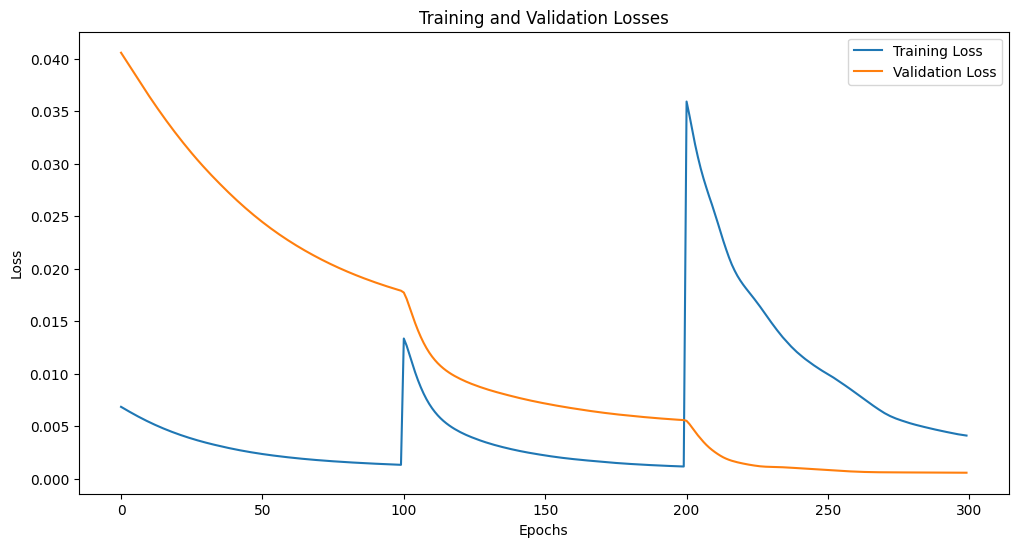

In [7]:
# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(all_train_losses, label='Training Loss')
plt.plot(all_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

In [ ]:
# Convert the recorded losses into a DataFrame
loss_df = pd.DataFrame({
    'Epoch': list(range(1, len(all_train_losses) + 1)),
    'Training_Loss': all_train_losses,
    'Validation_Loss': all_val_losses
})

# Save the DataFrame to a CSV file
loss_df.to_csv('losses.csv', index=False)


In [8]:
# Function to sample part of the training data and evaluate model's performance
def sample_and_evaluate(num_samples=20):
    indices = np.random.choice(len(X_train[0]), size=num_samples, replace=False)
    # indices = [i for i in range(10)]
    sampled_X = [tf.cast(X_train[0][indices], dtype=tf.float32), tf.cast(X_train[1][indices], dtype=tf.float32)]
    sampled_y = tf.cast(y_train[indices], dtype=tf.float32)
    loss = validate_step(sampled_X, sampled_y, print_results = True)
    print(f"Loss on sampled data: {loss.numpy()}")
    return loss.numpy()

In [9]:
X_train[0][0]

array([2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
sample_and_evaluate()

batched_errors:  [<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.05686548], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.07216448], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.       , 0.2193803], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.16778213], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.23472401], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.10291527], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.13007769], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.      , 0.013388], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.07944658], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.        , 0.10619263], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=arr

0.0058035315

In [ ]:
tf.shape(X_train)[0]

<tf.Tensor: shape=(), dtype=int32, numpy=272>

In [ ]:
apply_gate(np.array([1/np.sqrt(2), 0, 0, 1/np.sqrt(2)], dtype=np.float32), 0.5, 0)

current label:  0


array([0.70710677, 0.        , 0.        , 0.70710677], dtype=float32)

In [ ]:
test_vector = np.array(
    [[ 0.70710677],
     [-0.7064972 ],
     [ 0.        ],
     [-0.02935636]], dtype=np.float32)

In [ ]:
test_vector.shape

(4, 1)

In [ ]:
tf.squeeze(test_vector).shape

TensorShape([4])

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, 1], dtype=tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

In [ ]:
compute_probabilities(tf.constant([1, 0, 0, -1], dtype=tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.99999994>)

In [ ]:
# for i in range (tf.shape(X_train[:1])[0]):
#   single_sequence = tf.gather(X_train, i, axis=0)
#   print('single_sequence: ', single_sequence)
#   final_state = apply_gate_sequence(single_sequence)
#   print('final_state: ', final_state)
#   probabilities = compute_probabilities(final_state)
#   print('probabilities: ',probabilities )

In [ ]:
len(X_train[0])

20

In [ ]:
debug = tf.convert_to_tensor([[1, 0, 0, 0], [0, tf.math.cos(0.5), 0, tf.math.sin(0.5)],
                           [0, 0, 1, 0], [0, -tf.math.sin(0.5), 0, tf.math.cos(0.5)]], dtype=tf.float32)

In [ ]:
debug

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.87758255,  0.        ,  0.47942555],
       [ 0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        , -0.47942555,  0.        ,  0.87758255]],
      dtype=float32)>